# Predictability in ERA-Interim data

## Data-prep: monthly geopotential at 500hPa 1979-2014

In [1]:
# Display the plots in the notebook:
%matplotlib inline

In [2]:
# Import the tools we are going to need today:
import scipy
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import pandas as pd  # new package! this is the package at the base of xarray
# This just reads the data from an url
import io, requests
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size
np.set_printoptions(threshold=20)  # avoid to print very large arrays on screen
# The commands below are to ignore all warnings, careful!
import warnings
warnings.filterwarnings('ignore')

In [3]:
ds = xr.open_dataset('./data/ERA-Int-Monthly-500hPa-UVZ.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 432)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
    level      int32 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2014-12-01
Data variables:
    z          (time, latitude, longitude) float64 ...
    u          (time, latitude, longitude) float64 ...
    v          (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2016-12-11 21:53:11 GMT by grib_to_netcdf-2.0.2: grib_to_ne...

In [5]:
geop = ds.z / 9.81

### DJF and Nov averages

In [6]:
geop_djf = geop.where(ds['time.season'] == 'DJF')
geop_djf = geop_djf.rolling(min_periods=3, center=True, time=3).mean()
geop_djf = geop_djf.groupby('time.year').mean('time').isel(year=slice(1, 36))
geop_n = geop_djf*0 + geop.isel(time=ds['time.month'] == 11).isel(time=slice(0, -1)).data

### Anomalies 

In [7]:
geop_n = geop_n - geop_n.mean(dim='year')
geop_djf = geop_djf - geop_djf.mean(dim='year')

## Correlation of Nov geop anomaly to DJF anomaly at each grid point (i.e: persistence) 

In [8]:
cor = geop_djf.mean(dim='year') * 0.
for j in range(len(geop_n.latitude)):
    for i in range(len(geop_n.longitude)):
        cor.data[j, i] = np.corrcoef(geop_n.data[:, j, i], geop_djf.data[:, j, i])[0, 1]

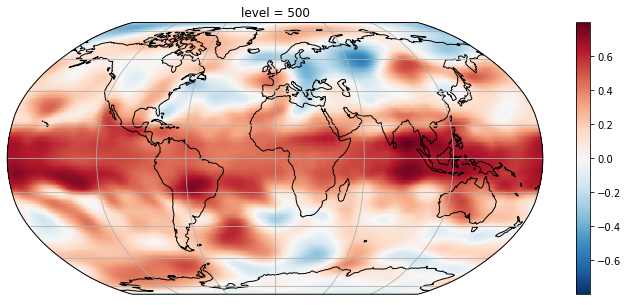

In [9]:
ax = plt.axes(projection=ccrs.Robinson())
cor.plot(ax=ax, transform=ccrs.PlateCarree()) 
ax.coastlines(); ax.gridlines();

### Time series of geop anomalies averaged in the tropics (20°S 20°N) 

In [10]:
tsn = geop_n.sel(latitude=slice(20, -20)).mean(dim=['longitude','latitude'])
tsdjf = geop_djf.sel(latitude=slice(20, -20)).mean(dim=['longitude','latitude'])

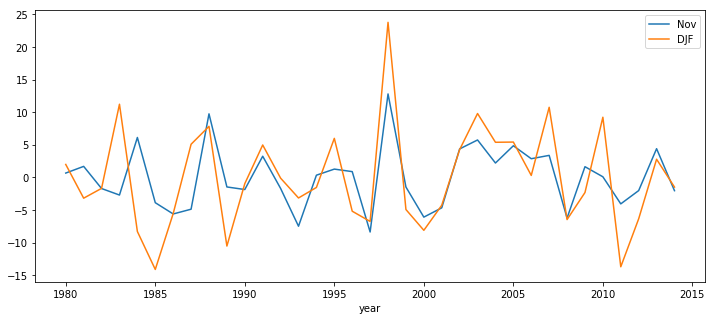

In [11]:
tsn.plot(label='Nov');
tsdjf.plot(label='DJF');
plt.title(''); plt.legend();

## Even better: point correlation of Nov geop anomaly at 150W at Equator (Niño 3.4 region) with DJF geop anomaly

In [12]:
cor_point = geop_djf.mean(dim='year') * 0.
cor_ts = geop_n.sel(longitude=-150., latitude=0).data
for j in range(len(geop_n.latitude)):
    for i in range(len(geop_n.longitude)):
        cor_point.data[j, i] = np.corrcoef(geop_djf.data[:, j, i], cor_ts)[0, 1]

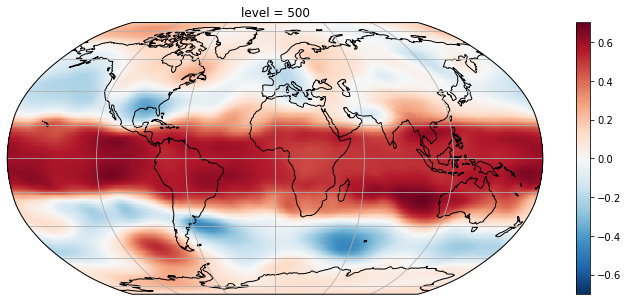

In [13]:
ax = plt.axes(projection=ccrs.Robinson())
cor_point.plot(ax=ax, transform=ccrs.PlateCarree()) 
ax.coastlines(); ax.gridlines();